<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Deep_Learning_Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
Epoch 1/10
87/87 [==============================] - 9s 55ms/step - loss: 0.0189
Epoch 2/10
87/87 [==============================] - 6s 70ms/step - loss: 6.2037e-04
Epoch 3/10
87/87 [==============================] - 5s 55ms/step - loss: 5.6611e-04
Epoch 4/10
87/87 [==============================] - 5s 58ms/step - loss: 5.3922e-04
Epoch 5/10
87/87 [==============================] - 6s 67ms/step - loss: 5.4870e-04
Epoch 6/10
87/87 [==============================] - 5s 55ms/step - loss: 5.0653e-04
Epoch 7/10
87/87 [==============================] - 6s 70ms/step - loss: 5.6954e-04
Epoch 8/10
87/87 [==============================] - 5s 55ms/step - loss: 5.3635e-04
Epoch 9/10
87/87 [==============================] - 5s 58ms/step - loss: 4.8962e-04
Epoch 10/10
21/21 [==============================] - 1s 17ms/step
Mean Squared Error: 0.0002729947590293797
Mean Absolute Error: 0.012520691344561243
1/1 [========================

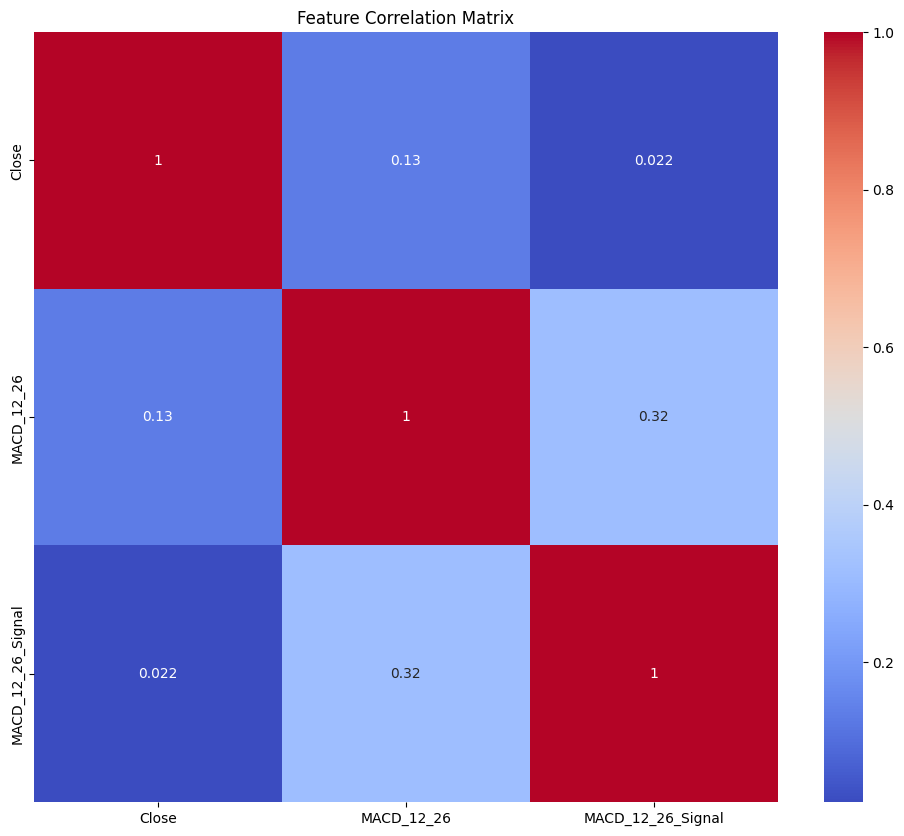

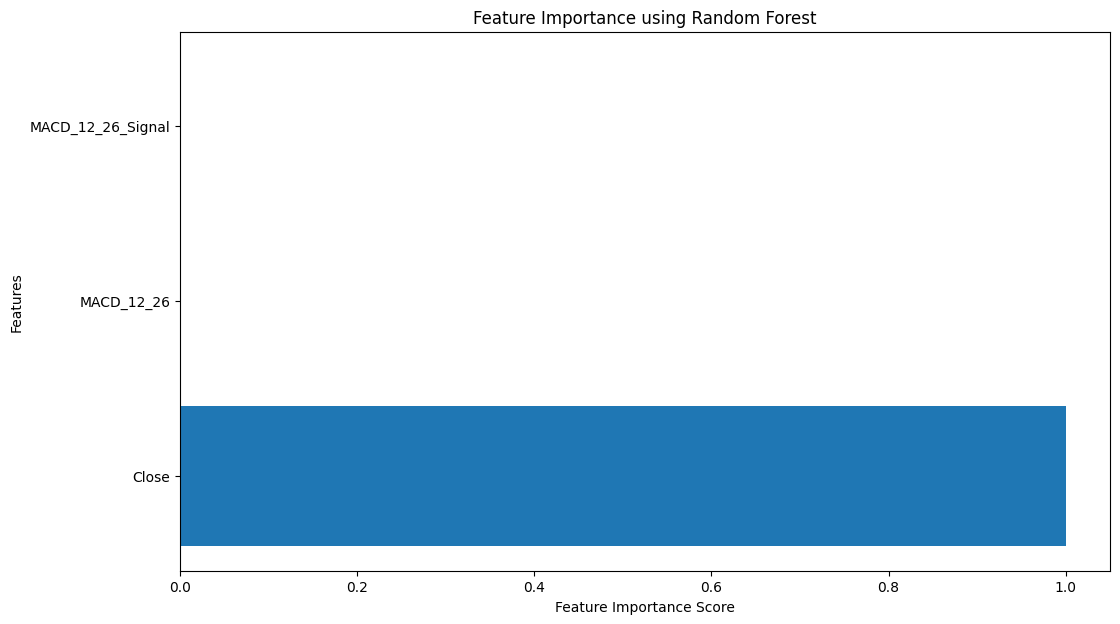

Selected Features: ['Close' 'MACD_12_26' 'MACD_12_26_Signal']
1/1 [==============================] - 0s 27ms/step


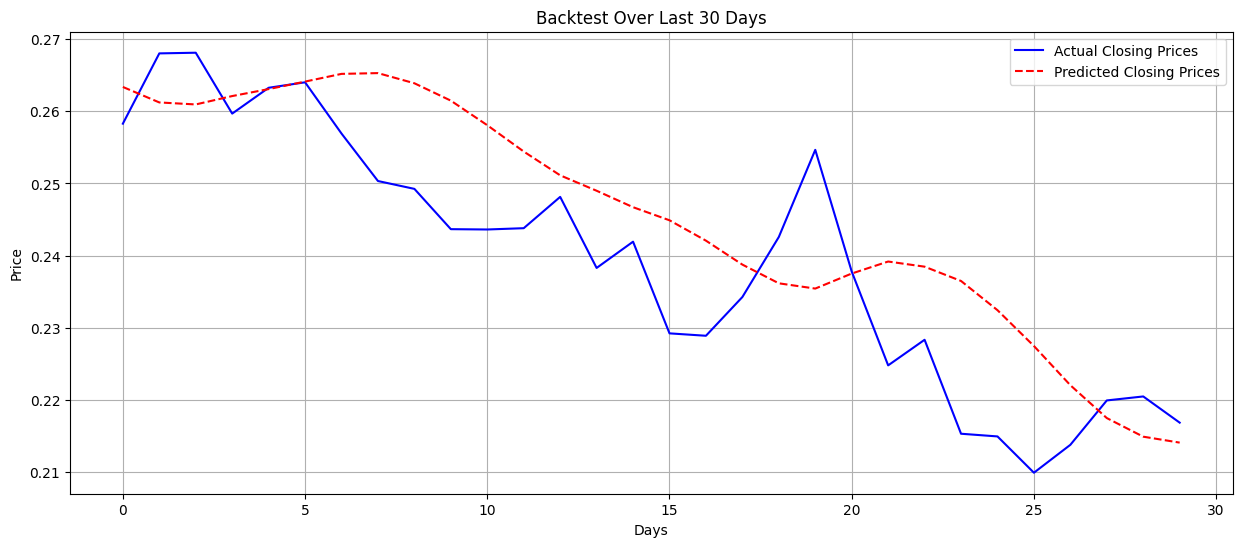

1/1 [==============================] - 0s 26ms/step


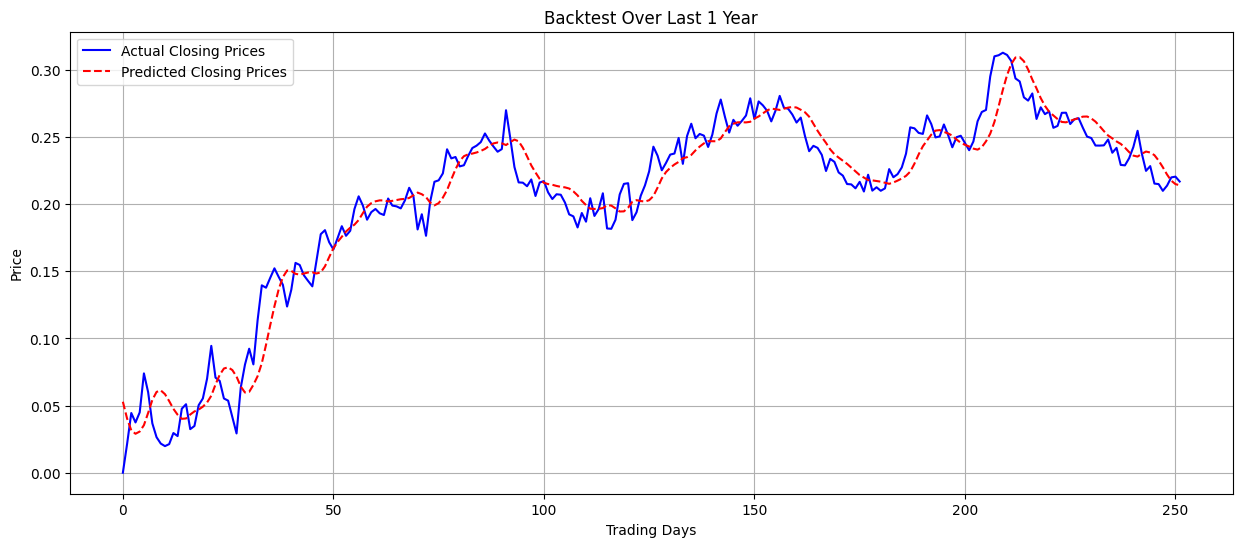

In [3]:
!pip install pandas_ta yfinance
!pip install matplotlib

import datetime
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Gather Data
#symbol = "EURAUD=X"
symbol = "EURUSD=X"


start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
df_euraud = yf.download(symbol, start=start_date, end=end_date, interval="1d")

# Calculate technical indicators
df_euraud["RSI"] = ta.rsi(df_euraud["Close"])
df_euraud[["MACD_12_26", "MACD_12_26_Signal", "MACD_12_26_Hist"]] = ta.macd(df_euraud["Close"])
df_euraud["ATR"] = ta.atr(df_euraud["High"], df_euraud["Low"], df_euraud["Close"])

# Drop NaN values and reset the index
df_euraud.dropna(inplace=True)
df_euraud.reset_index(drop=True, inplace=True)

# Preprocess Data
#input_features = ["Close", "RSI", "MACD_12_26", "MACD_12_26_Signal", "MACD_12_26_Hist", "ATR"]
#input_features = ['Close', 'RSI', 'MACD_12_26', 'MACD_12_26_Signal', 'MACD_12_26_Hist']
#input_features = ['Close', 'RSI', 'MACD_12_26', 'MACD_12_26_Signal']
input_features = ['Close', 'MACD_12_26', 'MACD_12_26_Signal']


df_scaler = MinMaxScaler()
df_euraud[input_features] = df_scaler.fit_transform(df_euraud[input_features])

close_scaler = MinMaxScaler()
df_euraud['Close'] = close_scaler.fit_transform(df_euraud[['Close']])

# Split Data
train_size = int(len(df_euraud) * 0.8)
train_data = df_euraud[:train_size]
test_data = df_euraud[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length - 1):
        sequence = data[i : i + seq_length][input_features].values
        label = data["Close"].iloc[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 60
train_x, train_y = create_sequences(train_data, seq_length)
test_x, test_y = create_sequences(test_data, seq_length)

# Build Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer="adam", loss="mean_squared_error")

# Train Model
model.fit(train_x, train_y, epochs=10, batch_size=32)

# Make Predictions
predictions = model.predict(test_x)
predictions = close_scaler.inverse_transform(predictions)

# Evaluate Model
mse = mean_squared_error(predictions, close_scaler.inverse_transform(test_y.reshape(-1, 1)))
mae = mean_absolute_error(predictions, close_scaler.inverse_transform(test_y.reshape(-1, 1)))

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Predict the next 6 days
next_6_days = [test_x[-1]]
for _ in range(6):
    predicted_value = model.predict(np.array([next_6_days[-1]]))[0][0]
    last_day_features = next_6_days[-1][-1].copy()
    last_day_features[0] = predicted_value
    new_day = np.concatenate((next_6_days[-1][1:], [last_day_features]), axis=0)
    next_6_days.append(new_day)

predicted_closes = [close_scaler.inverse_transform(np.array([[day[-1, 0]]]))[0][0] for day in next_6_days][1:]

# Loop for 5 times to get decisions for the 6 days, since there are 5 comparisons to make
decisions = ['Buy' if predicted_closes[i + 1] > predicted_closes[i] else 'Sell' if predicted_closes[i + 1] < predicted_closes[i] else 'Hold' for i in range(5)]

print(f"Predictions for the Next 6 Days: {predicted_closes}")
print(f"Predicted Action for the Next 5 Days based on the 6 Days predictions: {decisions}")

##############################################

##############################################
# Feature Selection
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# 1. Correlation Matrix
corr_matrix = df_euraud[input_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# 2. Feature Importance from Tree-Based Models
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_euraud[input_features][:train_size], df_euraud["Close"][:train_size])

plt.figure(figsize=(12, 7))
plt.barh(input_features, rf.feature_importances_)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()

# 3. Recursive Feature Elimination (RFE)
selector = RFE(rf, n_features_to_select=5, step=1)
selector = selector.fit(df_euraud[input_features][:train_size], df_euraud["Close"][:train_size])
selected_features = np.array(input_features)[selector.support_]
print("Selected Features:", selected_features)

##############################################
####################################################
###########################################################
####################################################################

import matplotlib.pyplot as plt
# Gather last 30 days of actual data
# Backtest for last 30 days
recent_data = close_scaler.inverse_transform(test_y[-30:].reshape(-1, 1))
predicted_30_days = []

# To backtest over 30 days, start 30 days before the end of test_x
start_idx = len(test_x) - 30

for idx in range(start_idx, len(test_x)):
    input_data = test_x[idx]
    predicted_value = model.predict(np.array([input_data]))[0][0]
    predicted_30_days.append(close_scaler.inverse_transform(np.array([[predicted_value]]))[0][0])

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(recent_data, label="Actual Closing Prices", color='blue')
plt.plot(predicted_30_days, label="Predicted Closing Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Backtest Over Last 30 Days")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()

#################################

# Extract pairs of features with high correlation
highly_correlated_pairs = []
threshold = 0.8

for column in corr_matrix.columns:
    for index in corr_matrix.index:
        # Only consider upper triangle of correlation matrix to avoid duplicate pairs
        if corr_matrix.columns.get_loc(column) > corr_matrix.index.get_loc(index):
            # Check for correlation above threshold or below negative threshold
            if abs(corr_matrix.loc[index, column]) > threshold:
                highly_correlated_pairs.append((index, column, corr_matrix.loc[index, column]))

# Print the highly correlated pairs
for pair in highly_correlated_pairs:
    print(f"Features '{pair[0]}' and '{pair[1]}' have a correlation of: {pair[2]:.2f}")

# Based on the output, decide which features to drop

import matplotlib.pyplot as plt

# Gather last 252 days of actual data (1 trading year)
recent_data = close_scaler.inverse_transform(test_y[-252:].reshape(-1, 1))
predicted_1_year = []

# To backtest over 252 days, start 252 days before the end of test_x
start_idx = len(test_x) - 252

for idx in range(start_idx, len(test_x)):
    input_data = test_x[idx]
    predicted_value = model.predict(np.array([input_data]))[0][0]
    predicted_1_year.append(close_scaler.inverse_transform(np.array([[predicted_value]]))[0][0])

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(recent_data, label="Actual Closing Prices", color='blue')
plt.plot(predicted_1_year, label="Predicted Closing Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Backtest Over Last 1 Year")
plt.xlabel("Trading Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()



Description:

This notebook provides a comprehensive framework to predict foreign exchange (forex) rates using technical analysis and deep learning. The given script focuses on predicting the EUR/USD forex rates but can be adapted for other currency pairs or financial instruments. The primary method is the use of Long Short-Term Memory networks (LSTM), a form of Recurrent Neural Networks (RNN), to predict future closing prices.

Key Components:

Data Gathering: Fetches historical forex rates for EUR/USD from Yahoo Finance, spanning from 2010 to the present date.
Technical Analysis: Computes technical indicators like RSI, MACD, and ATR for the historical data.
Data Preprocessing: Normalizes feature values and crafts sequences for LSTM training.
Model Building & Training: Constructs an LSTM model and trains it using the preprocessed sequences.
Evaluation: Computes Mean Squared Error (MSE) and Mean Absolute Error (MAE) on test data to assess model accuracy.
Predictive Action: Makes decisions (Buy, Sell, Hold) based on the predicted closing prices for the next 6 days.
Feature Selection: Explores feature selection methods, including correlation analysis, feature importance from Random Forest, and Recursive Feature Elimination (RFE).
Backtesting: Visualizes the model's performance over the last 30 days by comparing the actual vs. predicted closing prices.
Instructions for Use:

Installation: Start by installing the required libraries using the !pip install pandas_ta yfinance command.
Select Symbol: Choose your currency pair or financial instrument by setting the 'symbol' variable.
Run Entire Notebook: Execute all the cells. The notebook will fetch data, preprocess it, train the model, and make predictions.
Adjust Features: Based on the correlation heatmap and other feature selection techniques, decide on the features to be included in the model. You can comment/uncomment the input_features lines as needed.
Evaluate & Backtest: Observe the MSE and MAE values for model performance. Additionally, view the backtesting plot for the last 30 days to understand the model's predictive power visually.
Make Predictions: The model provides Buy, Sell, or Hold decisions for the next 6 days based on predicted closing prices.
Customize: Feel free to tweak hyperparameters, LSTM architecture, or even include other technical indicators for enhanced predictions.
Note: Forex markets are influenced by a multitude of factors. While technical indicators can provide insights, it's essential to combine these with fundamental analysis and other research methods for a holistic trading strategy. Always trade responsibly.